In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os
import xgboost as xgb
import dask.array as da
import dask.dataframe as dd
from sklearn.metrics import accuracy_score, confusion_matrix

#bikes data
folder_path = "data_2022/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
df_list = [dd.read_csv(file, assume_missing=True, dtype={'last_reported': 'float64','station_id':'float64','num_docks_available':'float64','is_returning':'float64','ttl':'float64', 'status':'object'}) for file in csv_files]
df_datos_bikes = dd.concat(df_list, ignore_index=True)

#stations info + external sources
stations_info = pd.read_csv('data/stations_info/stations.csv')
calendar = pd.read_csv('calendar.csv')
metro = pd.read_csv('metro_bcn.csv')

In [209]:
from geopy.distance import geodesic

# Function to calculate the Haversine distance (in meters)
def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters


stations_info['nearest_station_id'] = None
stations_info['nearest_station_distance'] = None
stations_info['stations_within_100m'] = None
stations_info['stations_within_300m'] = None
stations_info['stations_within_500m'] = None

# Iterate over each station to calculate distance to other station
for idx, station in stations_info.iterrows():
    nearest_station = None
    nearest_distance = float('inf')
    count_100m = 0
    count_300m = 0
    count_500m = 0
    
    for jdx, other_station in stations_info.iterrows():
        if station['station_id'] != other_station['station_id']:
            distance = haversine(station['lat'], station['lon'], 
                                 other_station['lat'], other_station['lon'])
            if distance < nearest_distance:
                nearest_station = other_station['station_id']
                nearest_distance = distance
            
            if distance <= 100:
                count_100m += 1
            if distance <= 300:
                count_300m += 1
            if distance <= 500:
                count_500m += 1
    
    # Add into Dataframe
    stations_info.at[idx, 'nearest_station_id'] = nearest_station
    stations_info.at[idx, 'nearest_station_distance'] = nearest_distance
    stations_info.at[idx, 'stations_within_100m'] = count_100m
    stations_info.at[idx, 'stations_within_300m'] = count_300m
    stations_info.at[idx, 'stations_within_500m'] = count_500m

stations_info

,station_id,name,physical_configuration,lat,lon,altitude,address,cross_street,post_code,capacity,...,short_name,nearby_distance,_ride_code_support,rental_uris,is_valet_station,nearest_station_id,nearest_station_distance,stations_within_100m,stations_within_300m,stations_within_500m
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.3980,2.1801,16.0000,"GRAN VIA CORTS CATALANES, 760",02-Eixample/05-el Fort Pienc,"8,013.0000",46,...,1,"1,000.0000",True,NaN,NaN,119,244.8482,0,4,10
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.3955,2.1772,17.0000,"C/ ROGER DE FLOR, 126",02-Eixample/05-el Fort Pienc,"8,013.0000",29,...,2,"1,000.0000",True,NaN,NaN,387,130.3343,0,4,10
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.3942,2.1813,11.0000,"C/ NÀPOLS, 82",02-Eixample/05-el Fort Pienc,"8,013.0000",27,...,3,"1,000.0000",True,NaN,NaN,4,93.3674,1,2,12
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.3933,2.1812,8.0000,"C/ RIBES, 13",02-Eixample/05-el Fort Pienc,"8,013.0000",21,...,4,"1,000.0000",True,NaN,NaN,3,93.3674,1,5,11
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.3911,2.1802,7.0000,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)","01-CiutatVella/04-Sant Pere, Santa Caterina i ...","8,018.0000",39,...,5,"1,000.0000",True,NaN,NaN,418,6.9440,3,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,540,"C/ MANDONI, 6",ELECTRICBIKESTATION,41.3693,2.1426,18.0000,"C/ MANDONI, 6",03-Sants-Montjuïc/14-la Font de la Guatlla,"8,004.0000",20,...,521,1.0000,True,NaN,NaN,182,238.1651,0,1,4
512,541,"C/ MARBRE, 2",ELECTRICBIKESTATION,41.3614,2.1476,28.0000,"C/ MARBRE, 2",03-Sants-Montjuïc/13-la Marina de Port,"8,038.0000",28,...,524,"1,000.0000",True,NaN,NaN,537,438.0692,0,0,1
513,542,Copa América Barcelona - 542,VALET,41.3745,2.1892,NaN,Copa América Barcelona 2024,NaN,NaN,1,...,9000,1.0000,True,NaN,False,31,39.1129,2,2,4
514,543,Copa América Barcelona - 543,VALET,41.3838,2.1914,NaN,Copa América Barcelona 2024,NaN,NaN,1,...,9001,1.0000,True,NaN,False,116,8.7847,1,4,7


In [210]:
# Haversine formula to calculate the distance in meters
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Radius of the Earth in meters (mean radius)
    R = 6371000
    distance = R * c
    return distance


# Function to find nearest metro station for each bicycle station
def find_nearest_metro(stations_info, metro):
    nearest_metro_ids = []
    nearest_distances = []

    for _, bike_station in stations_info.iterrows():
        bike_lat = bike_station['lat']
        bike_lon = bike_station['lon']
        
        # Calculate the distance to each metro station and find the minimum
        distances = metro.apply(lambda row: haversine(bike_lon, bike_lat, row['longitude'], row['latitude']), axis=1)
        
        # Find the minimum distance and the corresponding metro station
        nearest_metro_id = metro.loc[distances.idxmin(), 'name']
        nearest_distance = distances.min()
        
        nearest_metro_ids.append(nearest_metro_id)
        nearest_distances.append(nearest_distance)
    
    stations_info['nearest_metro'] = nearest_metro_ids
    stations_info['distance_to_nearest_metro'] = nearest_distances

    return stations_info

# Apply the function
bicycle_stations_metro = find_nearest_metro(stations_info, metro)

In [212]:
#Transformamos en un formato de hora legible
df_datos_bikes["last_reported"] = dd.to_datetime(df_datos_bikes["last_reported"], unit='s')

In [213]:
#Descomponemos el Datatime (last_reported)
df_datos_bikes["year"] = df_datos_bikes["last_reported"].dt.year
df_datos_bikes["month"] = df_datos_bikes["last_reported"].dt.month
df_datos_bikes["day"] = df_datos_bikes["last_reported"].dt.day
df_datos_bikes["hour"] = df_datos_bikes["last_reported"].dt.hour

In [214]:
df_datos_bikes.dropna(subset=['last_reported'])

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl,year,month,day,hour
npartitions=48,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,datetime64[ns],bool,object,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [215]:
df_final = df_datos_bikes.groupby(['station_id', 'year', 'month', 'day', 'hour'])[['num_docks_available','num_bikes_available']].median().round(2).reset_index()

In [216]:
#df_final.compute().head(50)

In [217]:
# Asegurar que 'result' es un DataFrame de Pandas
if not isinstance(df_final, pd.DataFrame):
    df_final = df_final.compute()  # Convertir de Dask a Pandas si es necesario

In [218]:
# Configura la visualización de pandas para mostrar números con 2 decimales
pd.options.display.float_format = '{:,.4f}'.format

# Luego, realiza la operación de groupby y median
#df_final = df_datos_bikes.groupby(['station_id', 'year', 'month', 'day', 'hour'])[['num_docks_available', 'num_bikes_available']].median().reset_index()

# Redondea los resultados a 2 decimales si es necesario
df_final = df_final.round(4)

In [219]:
df_final.head()

,station_id,year,month,day,hour,num_docks_available,num_bikes_available
0,1.0000,2022,10,31,22,13.0000,31.0000
1,11.0000,2022,10,31,22,35.0000,0.0000
2,14.0000,2022,10,31,22,1.0000,25.0000
3,18.0000,2022,10,31,22,13.0000,7.0000
4,19.0000,2022,10,31,22,7.0000,21.0000


In [220]:
df_final = df_final.loc[df_final['year'] != 1970]
#df_final = df_final.loc[df_final['year'] != 2021]
df_final[['station_id','year','month','day','hour']] = df_final[['station_id','year','month','day','hour']].astype(int)
df_final.year.unique()

array([2022, 2021])

In [221]:
# Unir los DataFrames usando 'station_id' como clave
merged_df = pd.merge(df_final, stations_info, on="station_id", how="left")

# Mostrar las primeras filas del resultado
merged_df.head()

,station_id,year,month,day,hour,num_docks_available,num_bikes_available,name,physical_configuration,lat,...,_ride_code_support,rental_uris,is_valet_station,nearest_station_id,nearest_station_distance,stations_within_100m,stations_within_300m,stations_within_500m,nearest_metro,distance_to_nearest_metro
0,1,2022,10,31,22,13.0000,31.0000,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.3980,...,True,NaN,NaN,119,244.8482,0,4,10,Monumental,288.3065
1,11,2022,10,31,22,35.0000,0.0000,"PG. MARITIM, 11 (DAVANT PL. BRUGADA)",ELECTRICBIKESTATION,41.3824,...,True,NaN,NaN,12,110.9505,0,5,6,Ciutadella | Vila Olímpica,489.0176
2,14,2022,10,31,22,1.0000,25.0000,"AV. MARQUÉS DE L'ARGENTERA, 15",ELECTRICBIKESTATION,41.3848,...,True,NaN,NaN,9,35.7945,1,3,9,Barceloneta,305.0229
3,18,2022,10,31,22,13.0000,7.0000,"C/ ROSSELLÓ, 453",ELECTRICBIKESTATION,41.4061,...,True,NaN,NaN,496,147.0147,0,4,10,Sagrada Família,222.2605
4,19,2022,10,31,22,7.0000,21.0000,"C/ ROSSELLÓ, 354",ELECTRICBIKESTATION,41.4031,...,True,NaN,NaN,370,198.6951,0,3,8,Sagrada Família,280.0493


In [222]:
# Tenemos que cambiar capacity al max capacity de la estacion para que nos de como mucho 100% disponibilidad
merged_df['capacity'].fillna(merged_df['num_bikes_available'] + merged_df['num_docks_available'], inplace=True)

merged_df["num_docks_available_mod"] = merged_df['capacity'] - merged_df['num_bikes_available']

# Agregar la columna "percentage_docks_available"
merged_df["percentage_docks_available"] = merged_df["num_docks_available_mod"] / merged_df["capacity"]

# Opcional: llenar valores NaN si hay estaciones sin capacidad registrada
merged_df["percentage_docks_available"].fillna(0, inplace=True)

In [223]:
# Ordenar los datos correctamente antes de agrupar
df_prediction_task = merged_df.sort_values(
    by=['station_id', 'year', 'month', 'day', 'hour']
)

In [224]:
for i in range(1, 5):
    df_prediction_task = df_prediction_task.sort_values(by=['station_id','year', 'month', 'day', 'hour'])  # Ordena correctamente
    df_prediction_task[f'disponibilidad_porcentage_{i}h_antes'] = (
        df_prediction_task.groupby('station_id')['percentage_docks_available']
        .shift(i)  # Desplazamiento de i horas
        .fillna(0)  # Reemplaza NaN con 0
    )

In [225]:
# Ordenar cronológicamente y mostrar solo las columnas importantes
#df_prediction_task = df_prediction_task.sort_values(by=['year', 'month', 'day', 'hour'])

df_prediction_task[['station_id', 'year', 'month', 'day', 'hour', 
                   'percentage_docks_available', 
                   'disponibilidad_porcentage_1h_antes', 
                   'disponibilidad_porcentage_2h_antes', 
                   'disponibilidad_porcentage_3h_antes', 
                   'disponibilidad_porcentage_4h_antes']].head(10)  # Puedes ajustar el número de filas

,station_id,year,month,day,hour,percentage_docks_available,disponibilidad_porcentage_1h_antes,disponibilidad_porcentage_2h_antes,disponibilidad_porcentage_3h_antes,disponibilidad_porcentage_4h_antes
918933,1,2021,12,31,22,0.6087,0.0000,0.0000,0.0000,0.0000
3868831,1,2021,12,31,23,0.6196,0.6087,0.0000,0.0000,0.0000
3868928,1,2022,1,1,0,0.6957,0.6196,0.6087,0.0000,0.0000
181152,1,2022,1,1,1,0.7391,0.6957,0.6196,0.6087,0.0000
3869096,1,2022,1,1,2,0.7391,0.7391,0.6957,0.6196,0.6087
3869179,1,2022,1,1,3,0.7174,0.7391,0.7391,0.6957,0.6196
3869264,1,2022,1,1,4,0.7174,0.7174,0.7391,0.7391,0.6957
3869340,1,2022,1,1,5,0.6739,0.7174,0.7174,0.7391,0.7391
2395237,1,2022,1,1,6,0.6522,0.6739,0.7174,0.7174,0.7391
2395321,1,2022,1,1,7,0.6304,0.6522,0.6739,0.7174,0.7174


In [226]:
# elimino las 4 primeras filas, porque son primeros registros y tienen 0 en los antecedentes...
df_prediction_task = df_prediction_task.iloc[4:]

In [227]:
df_prediction_task.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'num_docks_available',
       'num_bikes_available', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'nearest_metro', 'distance_to_nearest_metro', 'num_docks_available_mod',
       'percentage_docks_available', 'disponibilidad_porcentage_1h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes'],
      dtype='object')

In [228]:
df_prediction_task.head()

,station_id,year,month,day,hour,num_docks_available,num_bikes_available,name,physical_configuration,lat,...,stations_within_300m,stations_within_500m,nearest_metro,distance_to_nearest_metro,num_docks_available_mod,percentage_docks_available,disponibilidad_porcentage_1h_antes,disponibilidad_porcentage_2h_antes,disponibilidad_porcentage_3h_antes,disponibilidad_porcentage_4h_antes
3869096,1,2022,1,1,2,34.0000,12.0000,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.3980,...,4,10,Monumental,288.3065,34.0000,0.7391,0.7391,0.6957,0.6196,0.6087
3869179,1,2022,1,1,3,33.0000,13.0000,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.3980,...,4,10,Monumental,288.3065,33.0000,0.7174,0.7391,0.7391,0.6957,0.6196
3869264,1,2022,1,1,4,33.0000,13.0000,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.3980,...,4,10,Monumental,288.3065,33.0000,0.7174,0.7174,0.7391,0.7391,0.6957
3869340,1,2022,1,1,5,31.0000,15.0000,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.3980,...,4,10,Monumental,288.3065,31.0000,0.6739,0.7174,0.7174,0.7391,0.7391
2395237,1,2022,1,1,6,29.0000,16.0000,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.3980,...,4,10,Monumental,288.3065,30.0000,0.6522,0.6739,0.7174,0.7174,0.7391


In [229]:
df_prediction_task['Date'] = pd.to_datetime(df_prediction_task[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

In [230]:
calendar['Date'] = pd.to_datetime(calendar['date'], errors='coerce')

In [231]:
df_prediction_task = df_prediction_task.merge(
    calendar[['Date','special_event']],  # Seleccionamos la columna específica de df_extra
    on='Date',  # Columna común para la fusión
    how='left'  # Realizamos el left join
)

In [232]:
df_prediction_task['special_event'] = df_prediction_task['special_event'].replace({True: 1, False: 0})
df_prediction_task['is_charging_station'] = df_prediction_task['is_charging_station'].replace({True: 1, False: 0})

In [233]:
# Agregar la columna 'is_weekend' (1 si es sábado o domingo, 0 en otros casos)
df_prediction_task['is_weekend'] = df_prediction_task['Date'].dt.weekday.isin([5, 6]).astype(int)

In [234]:
festivos_data = [
    (2022, 1, 1, "Año Nuevo"),
    (2022, 1, 6, "Reyes Magos"),
    (2022, 4, 15, "Viernes Santo"),
    (2022, 4, 18, "Lunes de Pascua"),
    (2022, 5, 1, "Día del Trabajador"),
    (2022, 6, 6, "Segunda Pascua (festivo local)"),
    (2022, 6, 24, "San Juan"),
    (2022, 8, 15, "La Asunción"),
    (2022, 9, 24, "La Mercè (festivo local)"),
    (2022, 10, 12, "Fiesta Nacional de España"),
    (2022, 11, 1, "Todos los Santos"),
    (2022, 12, 6, "Día de la Constitución"),
    (2022, 12, 8, "La Inmaculada"),
    (2022, 12, 25, "Navidad"),
    (2022, 12, 26, "San Esteban"),

    (2023, 1, 1, "Año Nuevo"),
    (2023, 1, 6, "Reyes Magos"),
    (2023, 4, 7, "Viernes Santo"),
    (2023, 4, 10, "Lunes de Pascua"),
    (2023, 5, 1, "Día del Trabajador"),
    (2023, 5, 29, "Segunda Pascua (festivo local)"),
    (2023, 6, 24, "San Juan"),
    (2023, 8, 15, "La Asunción"),
    (2023, 9, 11, "Diada de Cataluña"),
    (2023, 9, 25, "La Mercè (festivo local)"),
    (2023, 10, 12, "Fiesta Nacional de España"),
    (2023, 11, 1, "Todos los Santos"),
    (2023, 12, 6, "Día de la Constitución"),
    (2023, 12, 8, "La Inmaculada"),
    (2023, 12, 25, "Navidad"),
    (2023, 12, 26, "San Esteban"),

    (2024, 1, 1, "Año Nuevo"),
    (2024, 1, 6, "Reyes Magos"),
    (2024, 3, 29, "Viernes Santo"),
    (2024, 4, 1, "Lunes de Pascua"),
    (2024, 5, 1, "Día del Trabajador"),
    (2024, 5, 20, "Segunda Pascua (festivo local)"),
    (2024, 6, 24, "San Juan"),
    (2024, 8, 15, "La Asunción"),
    (2024, 9, 11, "Diada de Cataluña"),
    (2024, 9, 24, "La Mercè (festivo local)"),
    (2024, 10, 12, "Fiesta Nacional de España"),
    (2024, 11, 1, "Todos los Santos"),
    (2024, 12, 6, "Día de la Constitución"),
    (2024, 12, 8, "La Inmaculada"),
    (2024, 12, 25, "Navidad"),
    (2024, 12, 26, "San Esteban"),
]

# Crear el DataFrame
df_holidays = pd.DataFrame(festivos_data, columns=["year", "month", "day", "name"])

In [235]:
# Crear una nueva columna con la fecha completa en df_festivos
df_holidays["Date"] = pd.to_datetime(df_holidays[["year", "month", "day"]])

# Marcar si la fecha en df_prediction_task es un feriado
df_prediction_task["is_holiday"] = df_prediction_task["Date"].isin(df_holidays["Date"]).astype(int)

In [236]:
df_prediction_task['capacity'].unique()

array([46. , 29. , 27. , 21. , 39. , 43. , 35. , 26. , 54. , 42. , 30. ,
       18. , 19. , 17. , 23. , 15. , 20. , 19.5, 18.5, 20.5, 17.5, 16.5,
       16. , 15.5, 14. , 14.5, 13. , 12. , 10.5, 12.5, 13.5, 11.5, 11. ,
        6. ,  9.5,  0.5, 10. , 24. , 44. ,  8.5,  9. ,  5. ,  2.5,  1. ,
        7.5,  4. ,  2. ,  6.5,  0. ,  1.5,  3. , 47. , 31. ,  8. ,  7. ,
       25. , 32. , 40. , 48. , 33. , 22. , 34. , 36. , 25.5, 26.5, 24.5,
       23.5, 22.5, 21.5, 38. , 51. , 28. , 37. , 49. ])

In [237]:
#Get data from the nearest station
df_prediction_task = df_prediction_task.merge(df_prediction_task[['station_id', 'year', 'month', 'day', 'hour', 'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_2h_antes', 'disponibilidad_porcentage_3h_antes', 'disponibilidad_porcentage_4h_antes']], 
                     how='left', 
                     left_on=['nearest_station_id', 'year', 'month', 'day', 'hour'], 
                     right_on=['station_id', 'year', 'month', 'day', 'hour'], 
                     suffixes=('', '_nearest_station'))

In [238]:
# Filling N/As with Most Repeated Value
df_prediction_task.fillna(df_prediction_task.mode().iloc[0], inplace=True)

/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_7975/1881840262.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_prediction_task.fillna(df_prediction_task.mode().iloc[0], inplace=True)


In [239]:
# Only getting each 5th row to avoid having repeated data

df_prediction_sorted = df_prediction_task.sort_values(by=['station_id', 'year', 'month', 'day', 'hour']).reset_index(drop=True)
df_prediction_reduced = df_prediction_sorted.iloc[::5]

In [240]:
df_prediction_reduced.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'num_docks_available',
       'num_bikes_available', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'nearest_metro', 'distance_to_nearest_metro', 'num_docks_available_mod',
       'percentage_docks_available', 'disponibilidad_porcentage_1h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes', 'Date', 'special_event',
       'is_weekend', 'is_holiday', 'station_id_nearest_station',
       'disponibilidad_porcentage_1h_antes_nearest_station',
       'disponibilidad_porcentage_2h_antes_nearest_station',
       'di

In [241]:
df_prediction_reduced[['station_id', 'nearest_station_id', 'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_1h_antes_nearest_station']]

,station_id,nearest_station_id,disponibilidad_porcentage_1h_antes,disponibilidad_porcentage_1h_antes_nearest_station
0,1,119,0.7391,0.5641
5,1,119,0.6522,0.6154
10,1,119,0.6739,0.6667
15,1,119,0.7174,0.7436
20,1,119,0.6739,0.6154
...,...,...,...,...
4425445,532,392,0.0000,1.0000
4425450,532,392,0.0000,1.0000
4425455,532,392,0.0000,1.0000
4425460,532,392,0.0000,1.0000


In [242]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features (as provided) and the target variable
features = [
            'disponibilidad_porcentage_1h_antes',
            'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes']

# For demonstration purposes, assuming 'target_variable' is the target column you want to predict
target_variable = 'percentage_docks_available'

# Split data into features (X) and target (y)
X = df_prediction_reduced[features]
y = df_prediction_reduced[target_variable]

# Convert categorical columns into numeric if necessary (for example, 'station_id' could be categorical)
#X = pd.get_dummies(X, columns=['station_id'], drop_first=True)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.01534563222530939
Root Mean Squared Error: 0.12387748877544051
R-squared: 0.7864005487240124


In [243]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'day', 'hour','capacity',
       'is_weekend', 'is_holiday', 'altitude', 'post_code',
            'disponibilidad_porcentage_1h_antes',
            'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes',
            'disponibilidad_porcentage_1h_antes_nearest_station',
            'disponibilidad_porcentage_2h_antes_nearest_station', 
            'disponibilidad_porcentage_3h_antes_nearest_station', 
            'disponibilidad_porcentage_4h_antes_nearest_station',
            'nearest_station_distance','nearby_distance',
            'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
            'distance_to_nearest_metro']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
X = df_prediction_reduced[features]
y = df_prediction_reduced[target_variable]

# Convert categorical variables to numeric (for example, 'station_id')
#X = pd.get_dummies(X, drop_first=True)

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Get the summary of the model, including p-values
print(model.summary())


                                OLS Regression Results                                
Dep. Variable:     percentage_docks_available   R-squared:                       0.789
Model:                                    OLS   Adj. R-squared:                  0.789
Method:                         Least Squares   F-statistic:                 1.580e+05
Date:                        Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                                00:40:21   Log-Likelihood:             6.0000e+05
No. Observations:                      885094   AIC:                        -1.200e+06
Df Residuals:                          885072   BIC:                        -1.200e+06
Df Model:                                  21                                         
Covariance Type:                    nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [244]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the model (intercept term)
X = df_prediction_reduced[features]
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print(vif_data)

                                             Variable         VIF
0                                               month      1.0095
1                                                 day      1.0060
2                                                hour      1.0061
3                                            capacity      1.0795
4                                          is_weekend      1.0003
5                                          is_holiday      1.0104
6                                            altitude      1.4791
7                                           post_code      1.0650
8                  disponibilidad_porcentage_1h_antes      4.9117
9                  disponibilidad_porcentage_2h_antes      9.1361
10                 disponibilidad_porcentage_3h_antes      9.1314
11                 disponibilidad_porcentage_4h_antes      4.9329
12  disponibilidad_porcentage_1h_antes_nearest_sta...      5.1193
13  disponibilidad_porcentage_2h_antes_nearest_sta...      9.5507
14  dispon

Interpretation of VIF:
VIF < 5: Low collinearity (safe).

VIF between 5 and 10: Moderate collinearity.

VIF > 10: High collinearity (problematic).

Dealing with Collinearity:
If you find high collinearity:

Remove one of the correlated variables: If two variables are highly correlated, you might choose to drop one of them.

Principal Component Analysis (PCA): A dimensionality reduction technique to reduce multicollinearity by creating uncorrelated components.

Ridge or Lasso regression: Regularization methods can mitigate the impact of collinearity.

In [245]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday', 'altitude', 'post_code',
            'disponibilidad_porcentage_1h_antes',
            'disponibilidad_porcentage_2h_antes', 
            #'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes',
            'disponibilidad_porcentage_1h_antes_nearest_station',
            'disponibilidad_porcentage_2h_antes_nearest_station', 
            #'disponibilidad_porcentage_3h_antes_nearest_station', 
            'disponibilidad_porcentage_4h_antes_nearest_station',
            'nearest_station_distance', 'nearby_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m', 'distance_to_nearest_metro']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
# Drop rows with missing values in the features and target
df_prediction_reduced = df_prediction_reduced.dropna(subset=features + [target_variable])

X = df_prediction_reduced[features]
y = df_prediction_reduced[target_variable]

# Standardize the data (important for ridge regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression Model
ridge_model = Ridge(alpha=1.0)  # You can tune alpha later

# Fit the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Coefficients of the model
print(f"Ridge Coefficients: {ridge_model.coef_}")


Mean Squared Error: 0.015070602160376418
Ridge Coefficients: [ 1.87877723e-03  5.95969952e-07 -4.72236710e-04  1.95407476e-03
 -1.16630157e-04 -5.41802741e-04  1.10397824e-02  6.61979553e-04
  2.51719054e-01 -2.33066824e-02 -3.64814083e-04  2.68855630e-02
 -1.42309728e-02 -8.63412011e-03 -1.57419228e-03  0.00000000e+00
 -2.34286005e-04 -2.38510834e-03  2.49365438e-03  1.54613026e-04]


                                                    Coefficient  \
disponibilidad_porcentage_1h_antes                       0.2517   
disponibilidad_porcentage_1h_antes_nearest_station       0.0269   
disponibilidad_porcentage_2h_antes                      -0.0233   
disponibilidad_porcentage_2h_antes_nearest_station      -0.0142   
altitude                                                 0.0110   
disponibilidad_porcentage_4h_antes_nearest_station      -0.0086   
stations_within_500m                                     0.0025   
stations_within_300m                                    -0.0024   
capacity                                                 0.0020   
month                                                    0.0019   
nearest_station_distance                                -0.0016   
post_code                                                0.0007   
is_holiday                                              -0.0005   
hour                                                    -0.000

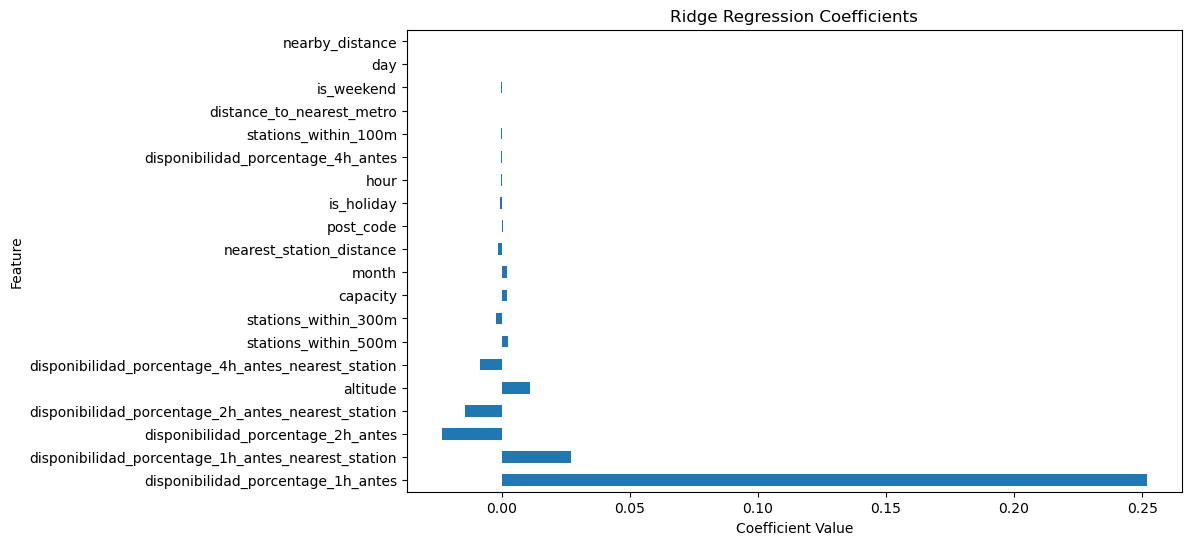

In [246]:

# Get the coefficients
coefficients = ridge_model.coef_

# Create a DataFrame to display the coefficients with feature names
coef_df = pd.DataFrame(coefficients, index=features, columns=['Coefficient'])

# Sort the coefficients by their absolute value (larger absolute values are more important)
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print or visualize the most important coefficients
print(coef_df)

# Optionally, you can visualize the coefficients
import matplotlib.pyplot as plt
coef_df['Coefficient'].plot(kind='barh', figsize=(10, 6))
plt.title("Ridge Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

R-squared: 0.8189
Mean Squared Error: 0.0130


<Figure size 1000x800 with 0 Axes>

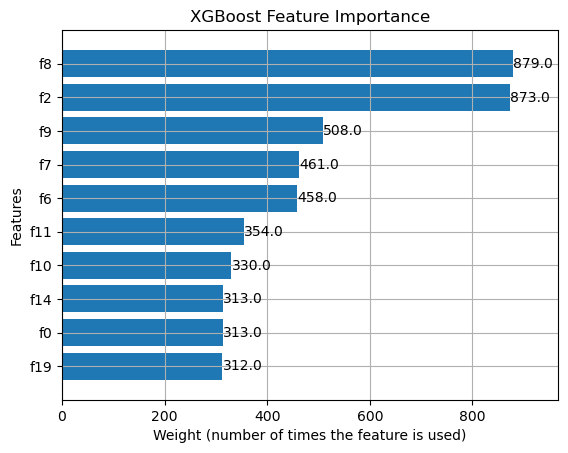

In [247]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday', 'post_code', 'altitude',
            'disponibilidad_porcentage_1h_antes',
            'disponibilidad_porcentage_2h_antes', 
            #'disponibilidad_porcentage_3h_antes',
            'disponibilidad_porcentage_4h_antes',
            'disponibilidad_porcentage_1h_antes_nearest_station',
            'disponibilidad_porcentage_2h_antes_nearest_station', 
            #'disponibilidad_porcentage_3h_antes_nearest_station', 
            'disponibilidad_porcentage_4h_antes_nearest_station',
            'nearest_station_distance', 'nearby_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m', 'distance_to_nearest_metro']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
df_prediction_reduced = df_prediction_reduced.dropna(subset=features + [target_variable])

X = df_prediction_reduced[features]
y = df_prediction_reduced[target_variable]

# Standardize the data (important for many ML algorithms, including XGBoost)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using R-squared and Mean Squared Error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Plot feature importance with custom column names (feature names should be directly from the model)
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, 
                    title='XGBoost Feature Importance', height=0.8, 
                    xlabel='Weight (number of times the feature is used)'
                   )
plt.show()


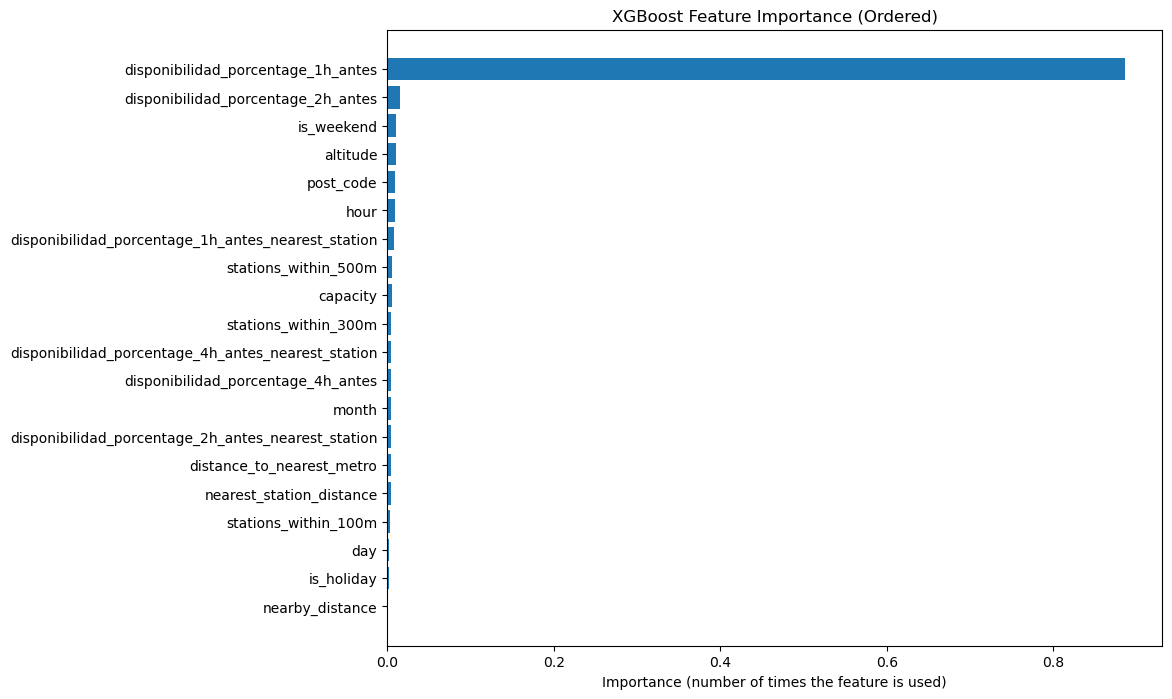

In [248]:
# Extract feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for importances and corresponding feature names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances according to the order in 'features'
importance_df = importance_df.set_index('Feature').loc[features]

importance_df_mod=importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importance in the same order as 'features'
plt.figure(figsize=(10, 8))

# Plot importance using 'weight' or another importance type
plt.barh(importance_df_mod.index, importance_df_mod['Importance'], align='center')
plt.xlabel('Importance (number of times the feature is used)')
plt.title('XGBoost Feature Importance (Ordered)')
plt.show()

Explained Variance Ratio of each component: [2.14898907e-01 1.36758346e-01 7.42570092e-02 6.42600330e-02
 5.75105836e-02 5.34039226e-02 5.29228451e-02 5.23231202e-02
 5.18973472e-02 4.71557129e-02 4.10559015e-02 4.00104530e-02
 2.79914937e-02 2.45418518e-02 2.13647439e-02 1.69687839e-02
 1.26623532e-02 5.58154549e-03 4.43504575e-03 9.20031992e-35]


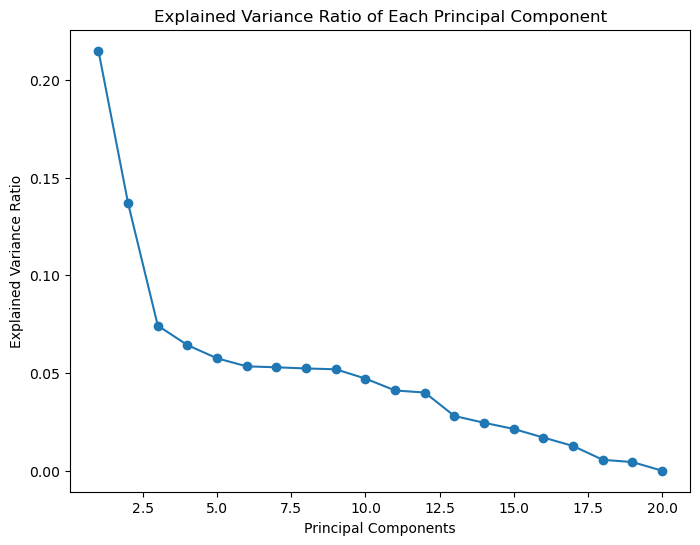

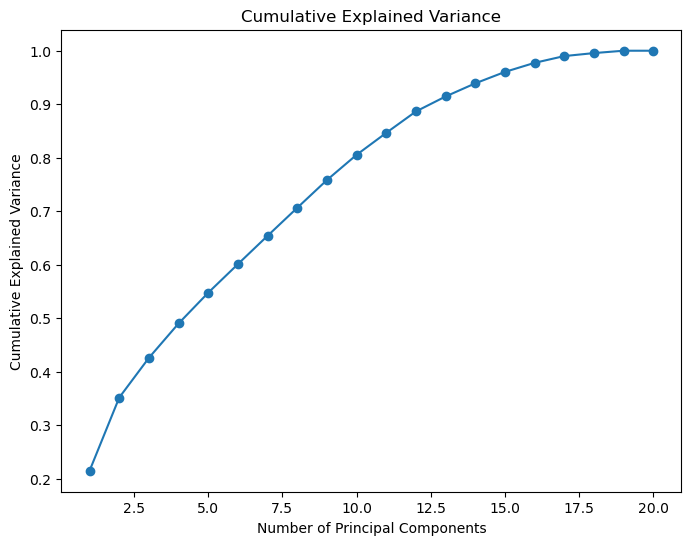

Number of components that explain 95% of the variance: 15


In [249]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual data)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features for PCA
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday', 'altitude', 'post_code',
            'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_2h_antes', 
            #'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes',
            'disponibilidad_porcentage_1h_antes_nearest_station',
            'disponibilidad_porcentage_2h_antes_nearest_station', 
            #'disponibilidad_porcentage_3h_antes_nearest_station', 
            'disponibilidad_porcentage_4h_antes_nearest_station',
            'nearest_station_distance', 'nearby_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m', 'distance_to_nearest_metro']

# Prepare the data
X = df_prediction_reduced[features]

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 3: Explained variance ratio to understand how much variance each component captures
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio of each component:", explained_variance)

# Step 4: Plot the explained variance to visualize the importance of each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Step 5: Cumulative Explained Variance (to decide how many components to retain)
cumulative_explained_variance = explained_variance.cumsum()
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Step 6: Choose the number of components based on cumulative explained variance (e.g., 95%)
n_components = 0
for i, variance in enumerate(cumulative_explained_variance):
    if variance >= 0.95:  # 95% explained variance
        n_components = i + 1
        break

print(f"Number of components that explain 95% of the variance: {n_components}")

# Step 7: Transform data to the selected number of principal components
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# You can now use X_pca_reduced for modeling (e.g., XGBoost, Ridge regression, etc.)

In [250]:
# Example using XGBoost after PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the reduced PCA data
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.7483
Mean Squared Error: 0.0181


In [251]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [252]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [253]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [254]:
df_prediction_reduced.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'num_docks_available',
       'num_bikes_available', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'nearest_metro', 'distance_to_nearest_metro', 'num_docks_available_mod',
       'percentage_docks_available', 'disponibilidad_porcentage_1h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes', 'Date', 'special_event',
       'is_weekend', 'is_holiday', 'station_id_nearest_station',
       'disponibilidad_porcentage_1h_antes_nearest_station',
       'disponibilidad_porcentage_2h_antes_nearest_station',
       'di

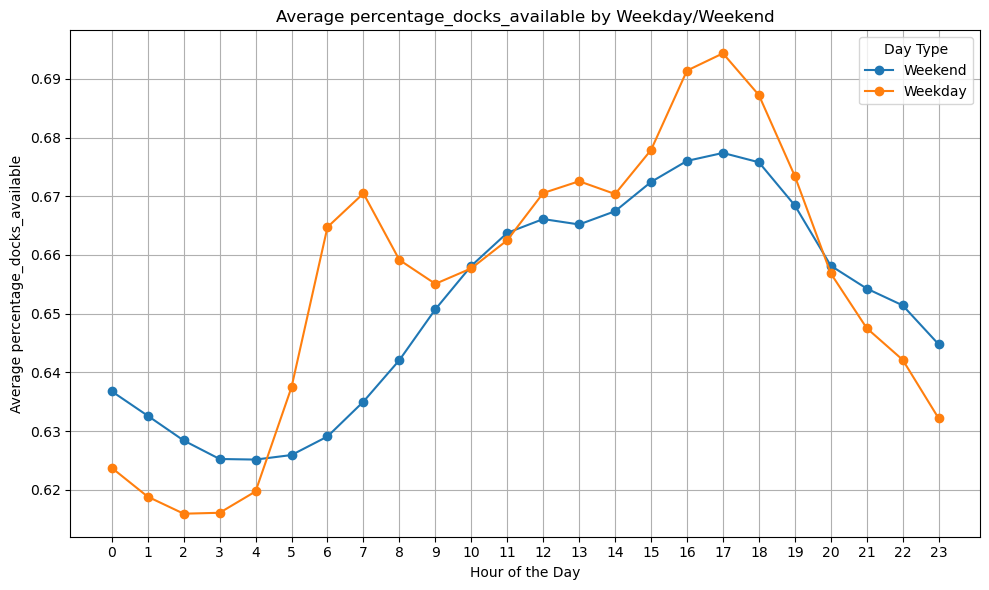

In [255]:
# Group the data by 'hour' and 'is_weekday' to calculate the average number of docks available per hour
hourly_docks = df_prediction_task.groupby(['hour', 'is_weekend'])['percentage_docks_available'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
for weekday in [True, False]:
    subset = hourly_docks[hourly_docks['is_weekend'] == weekday]
    plt.plot(subset['hour'], subset['percentage_docks_available'], label='Weekend' if weekday else 'Weekday', marker='o')

plt.title('Average percentage_docks_available by Weekday/Weekend')
plt.xlabel('Hour of the Day')
plt.ylabel('Average percentage_docks_available')
plt.legend(title='Day Type')
plt.grid(True)
plt.xticks(range(0, 24))  # Show hours 0-23 on the x-axis
plt.tight_layout()
plt.show()

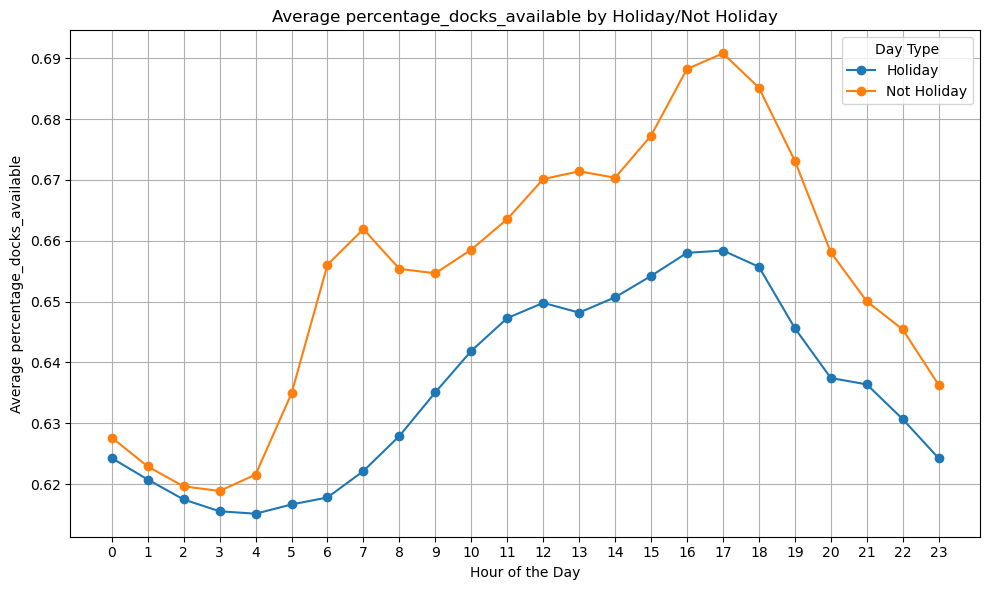

In [256]:
# Group the data by 'hour' and 'is_weekday' to calculate the average number of docks available per hour
hourly_docks = df_prediction_task.groupby(['hour', 'is_holiday'])['percentage_docks_available'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
for weekday in [True, False]:
    subset = hourly_docks[hourly_docks['is_holiday'] == weekday]
    plt.plot(subset['hour'], subset['percentage_docks_available'], label='Holiday' if weekday else 'Not Holiday', marker='o')

plt.title('Average percentage_docks_available by Holiday/Not Holiday')
plt.xlabel('Hour of the Day')
plt.ylabel('Average percentage_docks_available')
plt.legend(title='Day Type')
plt.grid(True)
plt.xticks(range(0, 24))  # Show hours 0-23 on the x-axis
plt.tight_layout()
plt.show()

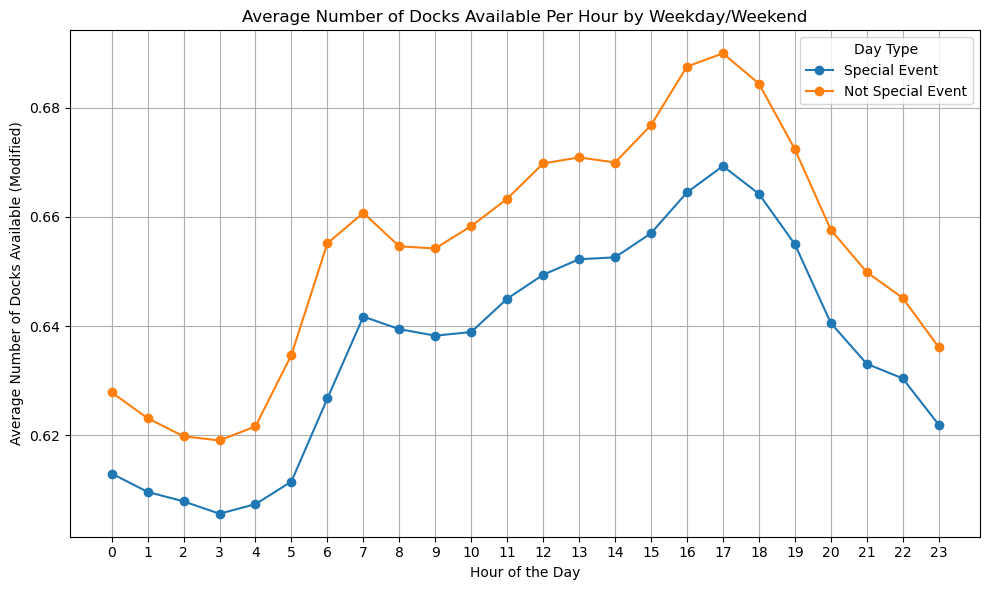

In [265]:
# Group the data by 'hour' and 'is_weekday' to calculate the average number of docks available per hour
hourly_docks = df_prediction_task.groupby(['hour', 'special_event'])['percentage_docks_available'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
for weekday in [True, False]:
    subset = hourly_docks[hourly_docks['special_event'] == weekday]
    plt.plot(subset['hour'], subset['percentage_docks_available'], label='Special Event' if weekday else 'Not Special Event', marker='o')

plt.title('Average Number of Docks Available Per Hour by Weekday/Weekend')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Docks Available (Modified)')
plt.legend(title='Day Type')
plt.grid(True)
plt.xticks(range(0, 24))  # Show hours 0-23 on the x-axis
plt.tight_layout()
plt.show()

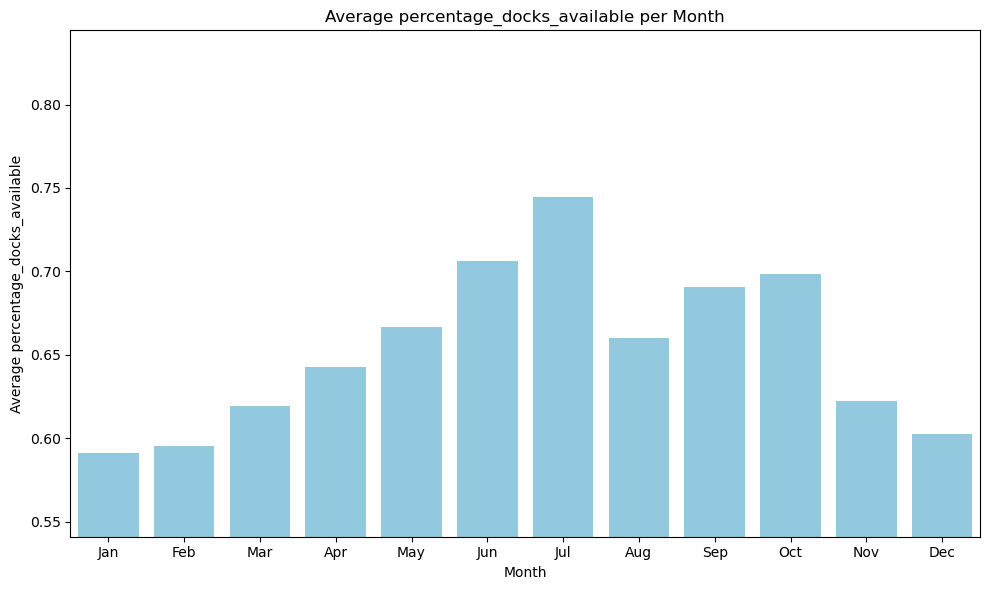

In [270]:
# Group by 'month' and calculate the average number of docks available (modified) for each month
monthly_avg_docks = df_prediction_reduced.groupby('month')['percentage_docks_available'].mean().reset_index()

# Plotting the results as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_avg_docks, x='month', y='percentage_docks_available', color='skyblue')
plt.ylim(monthly_avg_docks['percentage_docks_available'].min() - 0.05, monthly_avg_docks['percentage_docks_available'].max() + 0.1)
# Labels and title
plt.title('Average percentage_docks_available per Month')
plt.xlabel('Month')
plt.ylabel('Average percentage_docks_available')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.tight_layout()
plt.show()

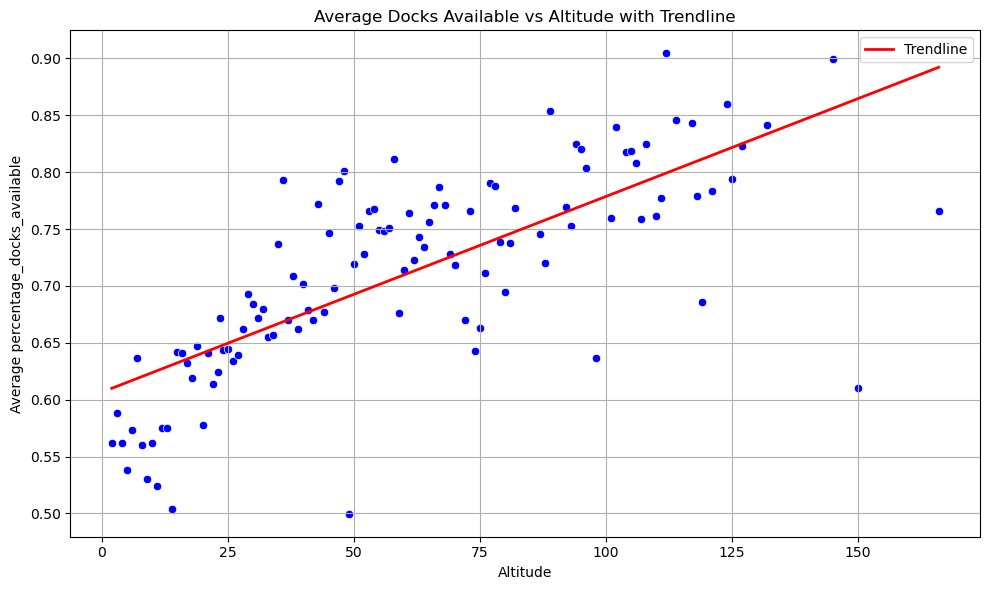

In [258]:
# Calculate the average number of docks available per altitude
altitude_avg_docks = df_prediction_reduced.groupby('altitude')['percentage_docks_available'].mean().reset_index()

# Scatter plot of the average values
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(data=altitude_avg_docks, x='altitude', y='percentage_docks_available', color='blue')

# Fit a linear regression model to the data
X = altitude_avg_docks[['altitude']]  # Independent variable (altitude)
y = altitude_avg_docks['percentage_docks_available']  # Dependent variable (average docks available)
model = LinearRegression()
model.fit(X, y)

# Predict y values using the model
y_pred = model.predict(X)

# Plot the trendline
plt.plot(altitude_avg_docks['altitude'], y_pred, color='red', linewidth=2, label='Trendline')

# Labels and title
plt.title('Average Docks Available vs Altitude with Trendline')
plt.xlabel('Altitude')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

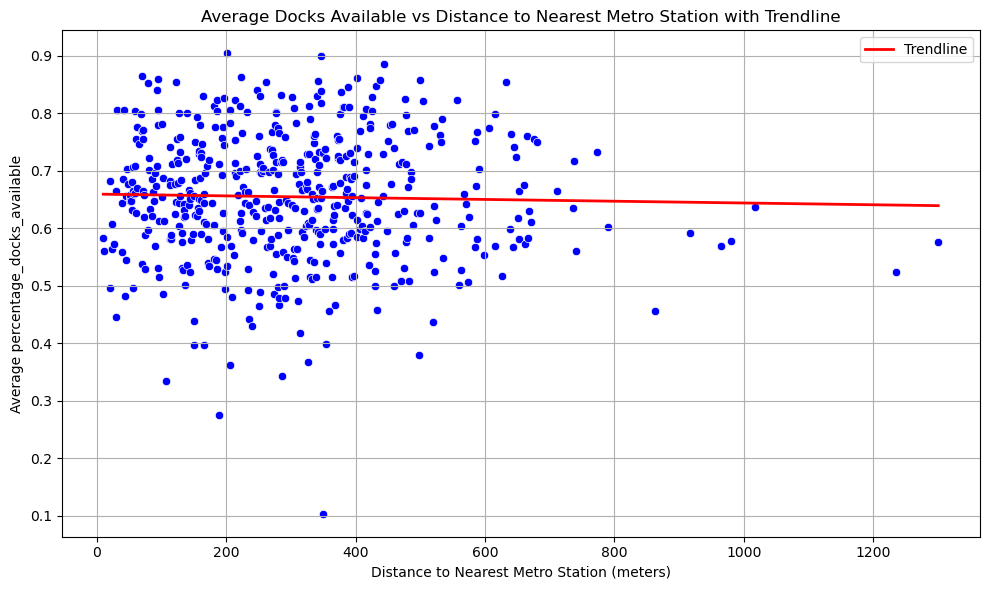

In [259]:
# Calculate the average number of docks available per distance to nearest metro station
distance_avg_docks = df_prediction_reduced.groupby('distance_to_nearest_metro')['percentage_docks_available'].mean().reset_index()

# Scatter plot of the average values
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(data=distance_avg_docks, x='distance_to_nearest_metro', y='percentage_docks_available', color='blue')

# Fit a linear regression model to the data
X = distance_avg_docks[['distance_to_nearest_metro']]  # Independent variable (distance to metro)
y = distance_avg_docks['percentage_docks_available']  # Dependent variable (average docks available)
model = LinearRegression()
model.fit(X, y)

# Predict y values using the model
y_pred = model.predict(X)

# Plot the trendline
plt.plot(distance_avg_docks['distance_to_nearest_metro'], y_pred, color='red', linewidth=2, label='Trendline')

# Labels and title
plt.title('Average Docks Available vs Distance to Nearest Metro Station with Trendline')
plt.xlabel('Distance to Nearest Metro Station (meters)')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

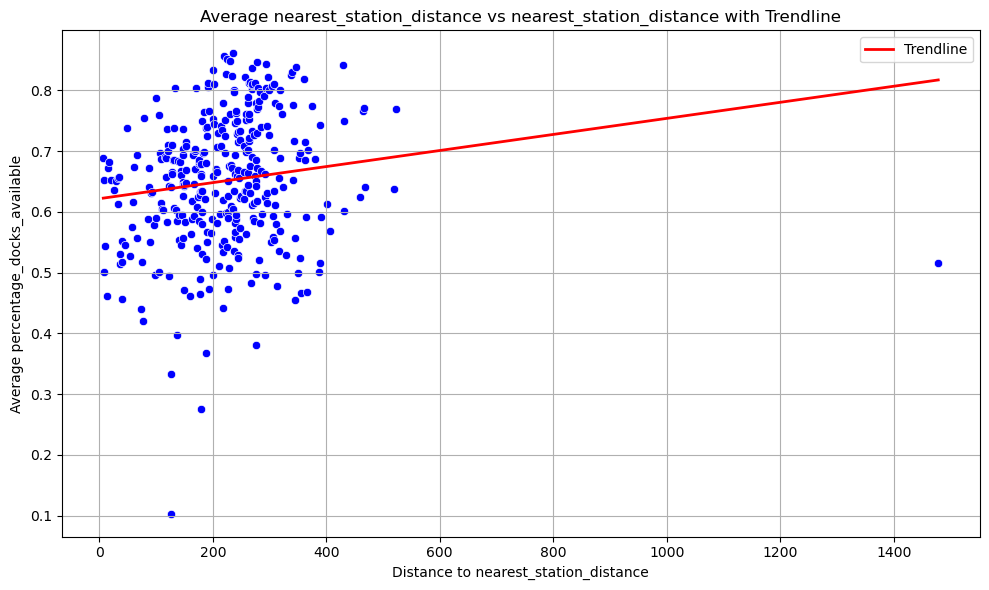

In [271]:
# Calculate the average number of docks available per distance to nearest metro station
distance_avg_docks = df_prediction_reduced.groupby('nearest_station_distance')['percentage_docks_available'].mean().reset_index()

# Scatter plot of the average values
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(data=distance_avg_docks, x='nearest_station_distance', y='percentage_docks_available', color='blue')

# Fit a linear regression model to the data
X = distance_avg_docks[['nearest_station_distance']]  # Independent variable (distance to metro)
y = distance_avg_docks['percentage_docks_available']  # Dependent variable (average docks available)
model = LinearRegression()
model.fit(X, y)

# Predict y values using the model
y_pred = model.predict(X)

# Plot the trendline
plt.plot(distance_avg_docks['nearest_station_distance'], y_pred, color='red', linewidth=2, label='Trendline')

# Labels and title
plt.title('Average nearest_station_distance vs nearest_station_distance with Trendline')
plt.xlabel('Distance to nearest_station_distance')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

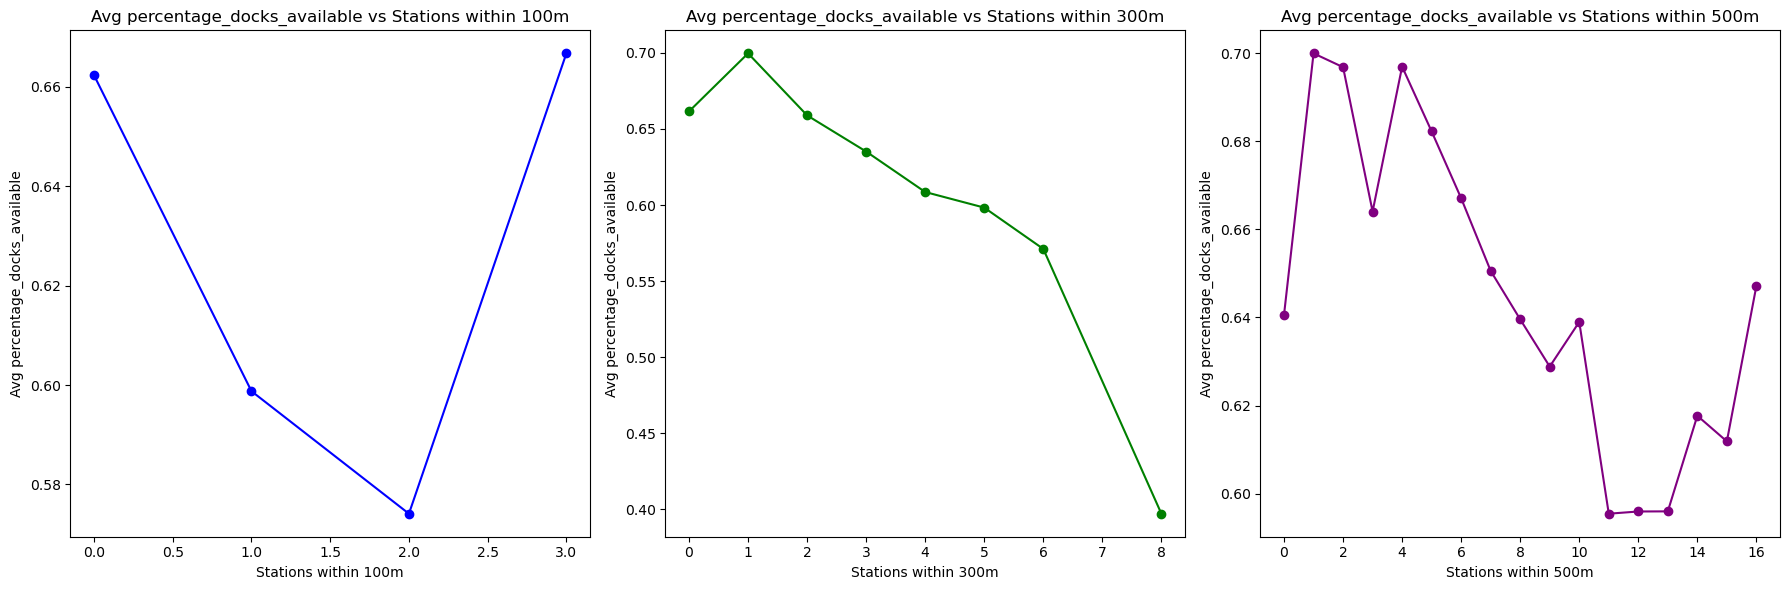

In [260]:
stations_within_100m_avg = df_prediction_reduced.groupby('stations_within_100m')['percentage_docks_available'].mean().reset_index()
stations_within_300m_avg = df_prediction_reduced.groupby('stations_within_300m')['percentage_docks_available'].mean().reset_index()
stations_within_500m_avg = df_prediction_reduced.groupby('stations_within_500m')['percentage_docks_available'].mean().reset_index()

# Create a plot for each proximity measure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Line chart for stations within 100m
axes[0].plot(stations_within_100m_avg['stations_within_100m'], stations_within_100m_avg['percentage_docks_available'], marker='o', color='blue')
axes[0].set_title('Avg percentage_docks_available vs Stations within 100m')
axes[0].set_xlabel('Stations within 100m')
axes[0].set_ylabel('Avg percentage_docks_available')

# Line chart for stations within 300m
axes[1].plot(stations_within_300m_avg['stations_within_300m'], stations_within_300m_avg['percentage_docks_available'], marker='o', color='green')
axes[1].set_title('Avg percentage_docks_available vs Stations within 300m')
axes[1].set_xlabel('Stations within 300m')
axes[1].set_ylabel('Avg percentage_docks_available')

# Line chart for stations within 500m
axes[2].plot(stations_within_500m_avg['stations_within_500m'], stations_within_500m_avg['percentage_docks_available'], marker='o', color='purple')
axes[2].set_title('Avg percentage_docks_available vs Stations within 500m')
axes[2].set_xlabel('Stations within 500m')
axes[2].set_ylabel('Avg percentage_docks_available')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

In [274]:
n_stations = df_prediction_reduced.groupby(['stations_within_300m'])['station_id'].nunique().reset_index()
n_stations

,stations_within_300m,station_id
0,0,70
1,1,121
2,2,135
3,3,92
4,4,50
5,5,33
6,6,9
7,8,1


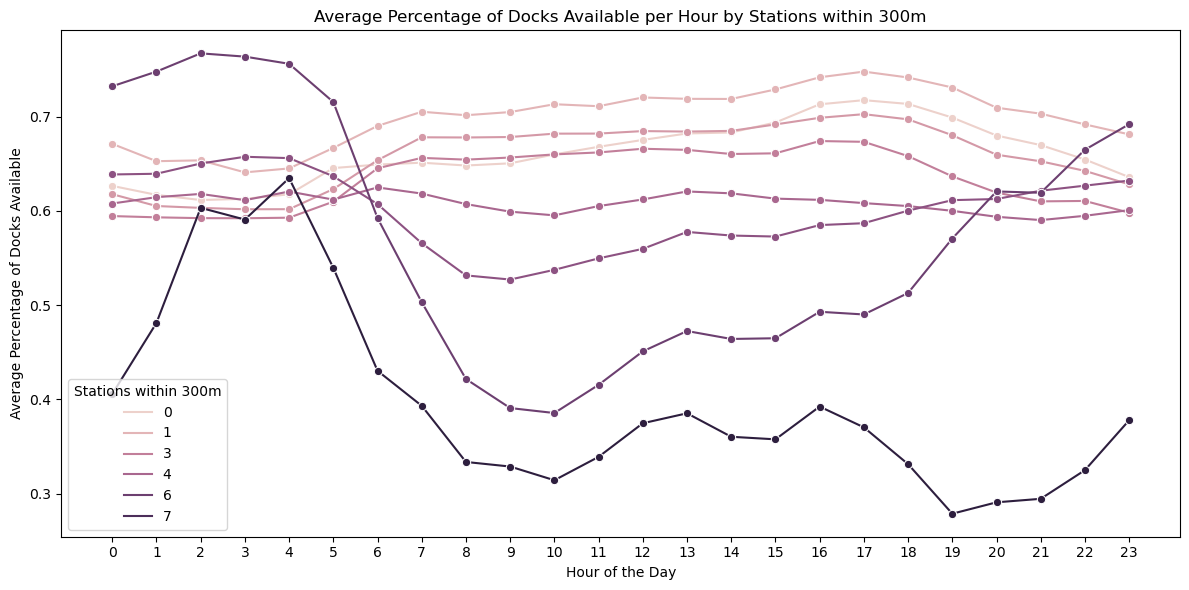

In [273]:
# Group by 'hour' and 'stations_within_300m' to calculate the average 'percentage_docks_available'
hourly_avg_docks = df_prediction_reduced.groupby(['hour', 'stations_within_300m'])['percentage_docks_available'].mean().reset_index()

# Plotting the results as a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_avg_docks, x='hour', y='percentage_docks_available', hue='stations_within_300m', marker='o')

# Labels and title
plt.title('Average Percentage of Docks Available per Hour by Stations within 300m')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Percentage of Docks Available')
plt.xticks(range(0, 24))  # Ensure hours are shown from 0 to 23
plt.legend(title='Stations within 300m')

# Show the plot
plt.tight_layout()
plt.show()


In [261]:
# Group by 'nearest_metro' and calculate the number of distinct station_id and the average number of docks available
metro_stats = df_prediction_reduced.groupby('nearest_metro').agg(
    num_distinct_stations=('station_id', 'nunique'),
    percentage_docks_available=('percentage_docks_available', 'mean')
).reset_index()

metro_stats_sorted = metro_stats.sort_values(by='num_distinct_stations', ascending=False)

# Get the top 10 and bottom 10 rows
top_10 = metro_stats_sorted.head(10)
bottom_10 = metro_stats_sorted.tail(10)

# Combine the top 10 and bottom 10 into one dataframe for easy display
final_df = pd.concat([top_10, bottom_10])

final_df.head(20)

,nearest_metro,num_distinct_stations,percentage_docks_available
15,Ciutadella | Vila Olímpica,23,0.5720
5,Barceloneta,15,0.5023
67,Poblenou,14,0.5643
20,Drassanes,11,0.4831
35,Hospital Clínic,10,0.7428
74,Sant Andreu,9,0.6291
45,Llacuna,8,0.6546
4,Barcelona - Arc de Triomf,8,0.6424
49,Maria Cristina,8,0.7160
59,Paral·lel,8,0.5231


In [272]:
# For top 10
top_10_avg = top_10[['num_distinct_stations', 'percentage_docks_available']].mean()

# For bottom 10
bottom_10_avg = bottom_10[['num_distinct_stations', 'percentage_docks_available']].mean()

# Combine both into a DataFrame for display
avg_df = pd.DataFrame({
    'Metric': ['Top 10 Average', 'Bottom 10 Average'],
    'Average Num Distinct Stations': [top_10_avg['num_distinct_stations'], bottom_10_avg['num_distinct_stations']],
    'Average percentage_docks_available': [top_10_avg['percentage_docks_available'], bottom_10_avg['percentage_docks_available']]
})

avg_df

,Metric,Average Num Distinct Stations,Average percentage_docks_available
0,Top 10 Average,11.4000,0.6030
1,Bottom 10 Average,1.0000,0.7299
